In [1]:
import multiprocessing as mp
import sys

import datamol as dm
import lohi_splitter as lohi
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import polaris as po
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import RDLogger
import seaborn as sns
from splito._scaffold_split import get_scaffold
from tqdm import tqdm

sys.path.append('../src')
from utils import ECFP_from_smiles, tanimoto_similarity, standardize_smiles

[18:58:35] Initializing Normalizer


In [2]:
logger = RDLogger.logger()
logger.setLevel(RDLogger.WARNING)

In [3]:
# @title Set an owner
owner = 'vladvin' # @param {type:"string"}
print(f"You have set \"{owner}\" as the owner")

You have set "vladvin" as the owner


In [4]:
benchmark = po.load_benchmark("polaris/adme-fang-solu-1")

2024-06-20 18:58:37.990 | INFO     | polaris._artifact:_validate_version:66 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (dev).
2024-06-20 18:58:38.005 | INFO     | polaris._artifact:_validate_version:66 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (dev).


In [5]:
train, test = benchmark.get_train_test_split()

In [6]:
len(train), len(test)

(1578, 400)

In [7]:
train = pd.DataFrame(train, columns=["smiles", "logS"])
test = pd.DataFrame(test, columns=["smiles"])

In [8]:
train

,smiles,logS
0,CCNc1ccnc(N(C)Cc2nc3ccccc3n2C)n1,1.567849
1,Clc1ccc(C2(c3ccc(-c4cn[nH]c4)cc3)CCNCC2)cc1,1.267172
2,c1ccc(-n2ncc3c(-n4ccnc4)ncnc32)cc1,0.696356
3,CCNC(=O)c1ccc(CS(C)(=O)=O)cc1,1.611723
4,Cc1ccnc(NC(=O)CN(C)C(=O)c2ccc(Cl)cc2)c1,1.801404
...,...,...
1573,Cc1c(C(=O)NC2CCN(CC3CCCCC3)CC2)cnn1C,1.689664
1574,O=C(Nc1ccc(F)cc1F)N1CCn2c1nc1ccccc12,0.785330
1575,O=c1c2cc(OCc3ccc(Cl)cc3)ccc2nc2n1CCCCC2,-0.420216
1576,Cc1cn(CCN2CCN(c3ccccc3-c3cc(C#N)cc(C(=O)NCCCN4...,1.501059


In [9]:
test

,smiles
0,CC(=O)Nc1ccnn1C1CCN(Cc2ccccc2C#Cc2ccccc2)CC1
1,Clc1cccc(Nc2ncnc3[nH]ncc23)c1Cl
2,NC(=O)Cn1c2ccccc2c2nc3ccccc3nc21
3,Cc1noc(CCNc2ncnc3ccccc23)n1
4,CCN1CCN(S(=O)(=O)Cc2ccc(Cl)c(Cl)c2)CC1
...,...
395,CN(C)C(=O)Cn1cc(C(=O)O)ccc1=O
396,Cc1cc(C)cc(C(=O)Nc2nn(C(C)(C)C)cc2C#N)c1
397,CCN(Cc1ccccc1)C(=O)c1cccnc1N
398,Cc1cc(F)c(C(=O)Nc2cccc(-c3nncn3C(C)C)n2)cc1-n1...


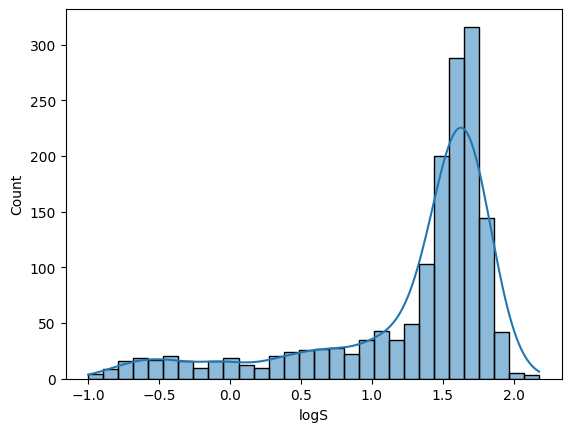

In [10]:
sns.histplot(train, x='logS', bins=30, kde=True);

In [11]:
train['S'] = 10**train['logS']

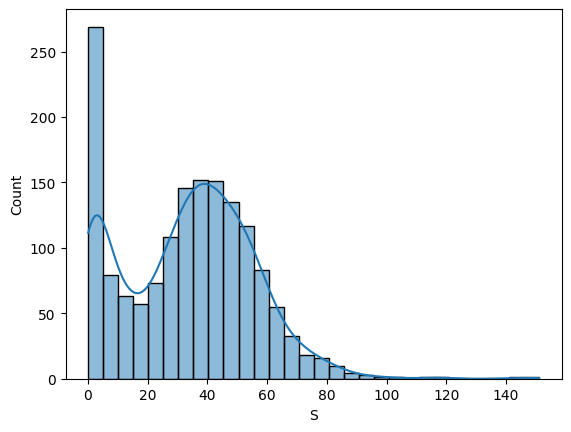

In [12]:
sns.histplot(train, x='S', bins=30, kde=True);

In [13]:
# train.to_csv('~/data/train.tsv', sep='\t', index=False)
# test.to_csv('~/data/test.tsv', sep='\t', index=False)

In [14]:
with mp.Pool(mp.cpu_count()) as pool:
    train_fps = np.array(list(tqdm(pool.imap(ECFP_from_smiles, train['smiles']), total=len(train))))
    test_fps = np.array(list(tqdm(pool.imap(ECFP_from_smiles, test['smiles']), total=len(test))))

100%|██████████| 400/400 [00:00<00:00, 1773.80it/s]


In [15]:
train2test_dists = tanimoto_similarity(train_fps, test_fps)
train2test_dists = train2test_dists.max(axis=0)
train2test_dists.shape

(400,)

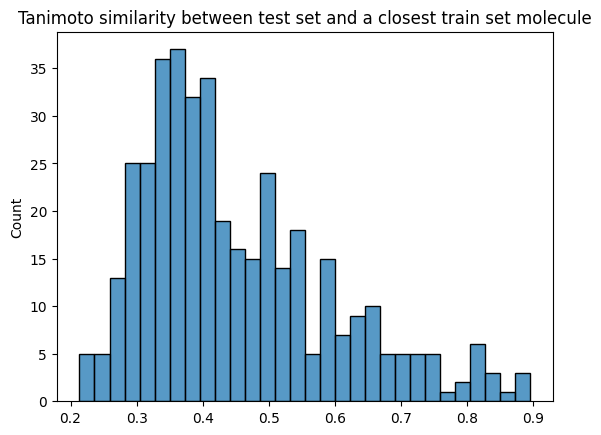

In [16]:
sns.histplot(train2test_dists, bins=30);
plt.title('Tanimoto similarity between test set and a closest train set molecule');

In [17]:
def smiles_to_scaffold_generic(smiles):
    mol = Chem.MolFromSmiles(smiles)
    scaffold = MurckoScaffold.MakeScaffoldGeneric(mol)
    scaffold = MurckoScaffold.GetScaffoldForMol(scaffold)
    scaffold_smiles = Chem.MolToSmiles(scaffold)

    return scaffold_smiles

In [18]:
train['is_multi_component'] = train['smiles'].str.contains('.', regex=False).astype(int)
test['is_multi_component'] = test['smiles'].str.contains('.', regex=False).astype(int)

print(f'Fraction of multi-component molecules in train set: {train["is_multi_component"].mean():.2f}')
print(f'Fraction of multi-component molecules in test set: {test["is_multi_component"].mean():.2f}')

Fraction of multi-component molecules in train set: 0.00
Fraction of multi-component molecules in test set: 0.00


In [19]:
with mp.Pool(mp.cpu_count()) as pool:
    train['smiles_std'] = list(tqdm(pool.imap(standardize_smiles, train['smiles']), total=len(train)))
    test['smiles_std'] = list(tqdm(pool.imap(standardize_smiles, test['smiles']), total=len(test)))

100%|██████████| 400/400 [00:00<00:00, 1535.95it/s]


In [20]:
train['smiles_std'].isna().sum(), test['smiles_std'].isna().sum()

(0, 0)

In [21]:
print(train['smiles'].nunique(), train['smiles_std'].nunique())
print(test['smiles'].nunique(), test['smiles_std'].nunique())

1578 1578
400 400


In [22]:
(train['smiles'] == train['smiles_std']).sum()

1578

In [23]:
(test['smiles'] == test['smiles_std']).sum()

400

In [24]:
with mp.Pool(mp.cpu_count()) as pool:
    train['scaffold'] = list(tqdm(pool.imap(smiles_to_scaffold_generic, train['smiles']), total=len(train)))
    test['scaffold'] = list(tqdm(pool.imap(smiles_to_scaffold_generic, test['smiles']), total=len(test)))

100%|██████████| 400/400 [00:00<00:00, 1977.03it/s]


In [25]:
train['scaffold'].nunique() / train['smiles'].nunique(), test['scaffold'].nunique() / test['smiles'].nunique()

(0.4873257287705957, 0.6825)

In [34]:
train = train.drop(['smiles_std', 'is_multi_component'], axis=1).reset_index(drop=True)
test = test.drop(['smiles_std', 'is_multi_component'], axis=1).reset_index(drop=True)

## Data splits

In [35]:
train_idx, valid_idx = lohi.hi_train_test_split(
    train['smiles'],
    similarity_threshold=0.4,
    train_min_frac=0.70,
    test_min_frac=0.17,
    coarsening_threshold=0.60,
    max_mip_gap=0.1
)

Total molecules in the giant component: 307
Min train size 214
Min test size 52
Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 987 (-554) rows, 554 (0) columns and 2524 (-1108) elements
Clp1000I sum of infeasibilities 2.30555e-07 - average 2.33592e-10, 0 fixed columns
Coin0506I Presolve 987 (0) rows, 554 (0) columns and 2524 (0) elements
Clp0006I 0  Obj 306.81338 Dual inf 87142.194 (554)
Clp0029I End of values pass after 554 iterations
Clp0014I Perturbing problem by 0.001% of 0.74871962 - largest nonzero change 2.9994078e-05 ( 0.0018300866%) - largest zero change 0
Clp0000I Optimal - objective value 307
Clp0000I Optimal - objective value 307
Clp0000I Optimal - objective value 307
Coin0511I After Postsolve, objective 307, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 307 - 0 iterations time 0.082, Presolve 0.00, Idiot 0.08

Starting MIP optimization
Cgl0004I processed model has 987 rows, 554 columns (554 in

In [36]:
len(train_idx) / (len(train_idx) + len(valid_idx))

0.8044444444444444

In [38]:
train.iloc[train_idx].to_csv('~/data/splits/hi/train.tsv', sep='\t', index=False)
train.iloc[valid_idx].to_csv('~/data/splits/hi/valid.tsv', sep='\t', index=False)